<a href="https://colab.research.google.com/github/tiasaxena/Pytorch/blob/main/05_pytorch_paper_replicating_attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Attention Is Your Need](https://arxiv.org/abs/1706.03762) - base model implementation from the paper

## 0. Import the libraries

In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00


In [2]:
import random
import math
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.trainers import BpeTrainer, WordLevelTrainer
from tokenizers.models import WordLevel, BPE
from tokenizers.pre_tokenizers import Whitespace,WhitespaceSplit

## 1. Configration of the model

In [3]:
config = dict(
  # RUN CONFIG
  RUN_NAME='unofficial_single_gpu_run',
  RUN_DESCRIPTION='No description',
  RUNS_FOLDER_PTH='../runs',

  # DATA CONFIG
  DATASET_SIZE = 30000, # This is though a small size dataset but it helps in training model quickly
  TEST_PROPORTION=0.01,
  MAX_SEQ_LEN=40,
  VOCAB_SIZE=60000,
  TOKENIZER_TYPE='wordlevel',

  # TRAINING CONFIG
  BATCH_SIZE=48,
  # * Gradient accumulation means that instead of updating weights every batch, we accumulate gradients over multiple smaller batches and then update.
  # * GRAD_ACCUMULATION_STEPS tells us how many steps we accumulate before updating the model.
  GRAD_ACCUMULATION_STEPS=2048//48, # Take the floor value
  WORKER_COUNT=10,
  EPOCHS=100,

  # OPTIMIZER CONFIG --> Taken from 5.3 section
  BETAS=(0.9, 0.98),
  EPS=1e-9,

  # SCHEDULAR CONFIG --> Taken from 5.3 section
  N_WARMUP_STEPS=4000,

  # MODEL_CONFIG --> Taken from Table 3
  D_MODEL=512,
  N_BLOCKS=6,
  N_HEADS=8,
  D_FF=2048,
  DROPOUT_PROBA=0.1,

  # OTHER
  MODEL_SAVE_EPOCH_CNT=10,
  DEVICE='gpu',
  LABEL_SMOOTHING=0.1, # --> Taken from 5.4 section
)

## 2. Dataset and Preprocessing

We will use HuggingFace Datasets library which will help us download and manipulate the dataset. `DATASET_SIZE` parameter in config will help us select and train only a part of the dataset, since whole dataset will take more training time and we lack the compute.

We will also be needing to **`flatten`** the dataset as we **want to remove all the nested structure in the dataset.**

E.g.,
```python
{
    'translation': [
        {'de': 'Hallo Welt', 'en': 'Hello World'},
        {'de': 'Guten Morgen', 'en': 'Good Morning'}
    ]
}

# We want to remove the nesting and brings all the field to the top level
 {
    'translation.de': ['Hallo Welt', 'Guten Morgen'],
    'translation.en': ['Hello World', 'Good Morning']
}

```

In [4]:
data=load_dataset('wmt14','de-en',split='train').shuffle(seed=42) # German-English
data=data.select(range(config['DATASET_SIZE'])) # Select a part of the entire dataset
data=data.flatten() # # Flatten the data
# Rename the column names
data=data.rename_column('translation.de','translation_trg')
data=data.rename_column('translation.en','translation_src')
data, data[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

(Dataset({
     features: ['translation_trg', 'translation_src'],
     num_rows: 30000
 }),
 {'translation_trg': 'In diesem Rubrik finden Sie Fahndungsmeldungen, die auf Anfrage eines Staatsanwalts oder Untersuchungsrichter verbreitet werden.',
  'translation_src': "On these pages you will find the wanted or missing notices that are issued at public prosecutor or examining magistrate's request."})

## 4. Create Tokenizer

In the research paper, `BPE` Tokenizer is used. Here, we use `WordLevel` tokenizer instead.

**Note:** Since a word-level tokenizer treats whole words as units (instead of breaking them into smaller subwords like BPE does), we need a larger vocabulary size than the 37,000-word vocabulary used in the paper.

E.g.,
```python
# BPE for "unhappiness is temporary"
["un", "happiness", "is", "temp", "orary"]

# WordLevel for "unhappiness is temporary"
["unhappiness", "is", "temporary"]
# Thus, every word is a separate token, meaning we need a larger vocabulary to store all possible words.
```

The process of creating a tokenizer boils down to selecting a tokenization model and customizing its components.

**Special tokens that are added**
1. **[BOS]** - Beginning of sentence. It is useful in the decoder input to signalize the beggining of a sentece, remember that the original transformer decoder predicts the next word in the sequence by looking at the encoder representation and the decoder input up to the current timestep.
2. **[EOS]** - End of sentence. [EOS] token signalizes the end of the sequence and therefore the end of decoding when inferencing.
3. **[PAD]** - Padding token
4. **[UNK]** - Unknown token encountered, which is not mentioned in the vocabulary.

STEPS FOR TOKENIZATION:
1. Normalize
2. Pre-tokenize
3. Tokenize
4. Post-Processor


We can do more [customization to our tokenizers](https://huggingface.co/docs/tokenizers/python/latest/components.html).

**Note:** While defining the tokenizers, we define the following -
* We have to choose a **tokenizer model**. Options -
  * BPE
  * WordLevel
  * WordPiece
  * Unigram
* We have to set a **Normalization** technique. A Normalizer is responsible for cleaning and standardizing the text before it gets tokenized. This helps ensure consistency in how words are processed. Options -
  * NFD
  * NFKD
  * NFC
  * NFKC
  * lowercase
  * strip
  * stripAccents
  * Replace
  * BERTNormalizer
  * Sequence
* We can set a **pre-tokenizer**(applied after normalization). A pre-tokenizer is responsible for splitting the input text into smaller units (tokens) before actual tokenization. It prepares the text for the main tokenization step by deciding where to split words, punctuation, or special characters. Suppose we don't want a ' ' char in vocab, so we can use Whitespace as a pre-tokenizer to remove it by splitting the sequences on ' '. Options -
  * Whitespace
  * WhitespaceSplit
  * Punctuation
  * Metaspace
  * CharDelimiterSplit
  * Digits
  * Split
  * Sequence
  * ByteLevel
* We set a **Post-processor**. A post-processor is applied after tokenization to modify or enhance the tokenized output. It typically adds special tokens (like `<sos>` and `<eos>`), formats token sequences, or adjusts token positions for model compatibility. Options -
  * TemplateProcessing

In [5]:
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]")) # All the unknown tokens, not found in vocab, must be replaced by `[UNK]`
# Add  a normalizer to the tokenizer
tokenizer.normalizer=normalizers.Sequence([NFD(),StripAccents(), Lowercase()])
# Add a pre-tokenizer
tokenizer.pre_tokenizer = WhitespaceSplit()
# Set up a trainer to create a word-level tokenizer with vocab_size = VOCAB_SIZE
trainer_src = WordLevelTrainer(vocab_size=config['VOCAB_SIZE'], special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"])

# Split the data into smaller batches of size batch_size and yield the text data to train the tokenizer
def batch_iterator_src(batch_size=10000):
  """
  At each iteration, the function returns a text chunk of size = batch_size and send it to the tokenizer to train it.
  """
  for i in range(0, len(data), batch_size):
    yield data[i : i + batch_size]['translation_src']
  for i in range(0, len(data), batch_size):
    yield data[i : i + batch_size]['translation_trg']

# Train the tokenizer
tokenizer.train_from_iterator(batch_iterator_src(), trainer=trainer_src, length=len(data))

# Add the post-processor to add [EOS] and [BOS] to the target sequence
tokenizer.post_processor = TemplateProcessing(
  # $A refers to each of the sequence, which is surrounded by [BOS] and [EOS]
  single="[BOS] $A [EOS]",
  # Assign a token id of 2 and 3 to [BOS] and [EOS] repectively.
  special_tokens=[
    ("[BOS]", 2),
    ("[EOS]", 3),
  ],
)

In [6]:
# Sample output from the tokenizer
encoding=tokenizer.encode('In diesem Rubrik finden Sie Fahndungsmeldungen, die auf Anfrage eines Staatsanwalts oder Untersuchungsrichter verbreitet werden.')

print('tokens: ', encoding.tokens)
print('ids: ',encoding.ids)

tokens:  ['[BOS]', 'in', 'diesem', 'rubrik', 'finden', 'sie', '[UNK]', 'die', 'auf', 'anfrage', 'eines', 'staatsanwalts', 'oder', 'untersuchungsrichter', 'verbreitet', 'werden.', '[EOS]']
ids:  [2, 5, 132, 6146, 437, 23, 1, 6, 27, 1979, 159, 53849, 63, 55851, 7490, 122, 3]


## 5. Preprocess the data

STEPS:
1. **Tokenize the dataset** → Convert sentences into token IDs.
2. **Filter long sentences** → Remove very long sentences so they fit into GPU memory.
3. **Split into train/test sets** → Divide the data into training and testing parts.
4. **Sort by length** → Arrange sentences from shortest to longest.

**Note:**
Why sorting?
* Groups similar-length sentences together in batches.
* Speeds up training because the model doesn’t waste time processing unnecessary padding.
* Uses fewer [PAD] tokens, making training more efficient.

In [7]:
def preprocess_data(data, tokenizer, max_seq_len, test_proportion):
  # 1. Tokenize the data
  def tokenize(example):
    return {
      'translation_src': tokenizer.encode(example['translation_src']).ids,
      'translation_trg': tokenizer.encode(example['translation_trg']).ids,
    }
  data=data.map(tokenize)
  print(f"Sample output of the tokenizer:\n {list(data)[0]}")
  print(f"Size of the data obtained after tokenization: {len(list(data))}")

  # 2. Compute and filter long sequences
  def sequence_length(example):
    return {
      'length_src': [len(item) for item in example['translation_src']],
      'length_trg': [len(item) for item in example['translation_trg']],
    }
  data=data.map(sequence_length, batched=True, batch_size=10000)
  print(f"Sample output of the length computation:\n {list(data)[0]}")

  # Filter by sequence lengths
  def filter_long(example):
    return example['length_src']<= max_seq_len and example['length_trg']<=max_seq_len
  data=data.filter(filter_long)
  print(f"Sample output of the length filtering:\n {list(data)[0]}")
  print(f"Size of the data obtained after filtering: {len(list(data))}")

  # 3. Split
  data=data.train_test_split(test_size=test_proportion)

  # 4. Sort each split by length for dynamic batching (see CustomBatchSampler)
  data['train']=data['train'].sort('length_src', reverse=True)
  data['test']=data['test'].sort('length_src', reverse=True)

  return data

In [8]:
data=preprocess_data(data, tokenizer, config['MAX_SEQ_LEN'], config['TEST_PROPORTION'])

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Sample output of the tokenizer:
 {'translation_trg': [2, 5, 132, 6146, 437, 23, 1, 6, 27, 1979, 159, 53849, 63, 55851, 7490, 122, 3], 'translation_src': [2, 21, 115, 936, 49, 52, 297, 4, 2111, 58, 5163, 32005, 14, 28, 6962, 56, 272, 32568, 58, 16990, 1, 5196, 3]}
Size of the data obtained after tokenization: 30000


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Sample output of the length computation:
 {'translation_trg': [2, 5, 132, 6146, 437, 23, 1, 6, 27, 1979, 159, 53849, 63, 55851, 7490, 122, 3], 'translation_src': [2, 21, 115, 936, 49, 52, 297, 4, 2111, 58, 5163, 32005, 14, 28, 6962, 56, 272, 32568, 58, 16990, 1, 5196, 3], 'length_src': 23, 'length_trg': 17}


Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Sample output of the length filtering:
 {'translation_trg': [2, 5, 132, 6146, 437, 23, 1, 6, 27, 1979, 159, 53849, 63, 55851, 7490, 122, 3], 'translation_src': [2, 21, 115, 936, 49, 52, 297, 4, 2111, 58, 5163, 32005, 14, 28, 6962, 56, 272, 32568, 58, 16990, 1, 5196, 3], 'length_src': 23, 'length_trg': 17}
Size of the data obtained after filtering: 25737


## 6. Create PyTorch Dataset and DataLoaders

### 6.1 Create Datasets

In [9]:
class TranslationDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    src_encoded=self.dataset[idx]['translation_src']
    trg_encoded=self.dataset[idx]['translation_trg']

    return (
      torch.tensor(src_encoded),
      torch.tensor(trg_encoded),
    )

train_ds=TranslationDataset(data['train'])
val_ds=TranslationDataset(data['test'])

len(train_ds), len(val_ds), train_ds[6]

(25479,
 258,
 (tensor([    2,    38,    84,    69,     5,   859,     7,    12, 16599,  3389,
             15,  2728,  1765,  5023,   468,     5,    24,  5413,    38,   322,
             14,     4, 40148,   198,  6678,   158,   662,  2621,     9,    12,
            539,   277,     7,   816,   407,    10,     1,    24, 52946,     3]),
  tensor([    2,    29,   924,   415,    43,    20,    35,  6489,    29, 22181,
             29, 29461,     1,     5,   132,   553,  3055,  1156,   113,     5,
             48,   212,    17,   363, 40148,   248,     6,   820,  3257, 13148,
            246,     6,    37, 23238,   823,     3])))

### 6.2 Create a function to pad the source and target sequences in a batch to same size

The [`padding_value`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) will be 0.

In [10]:
def pad_collate_fn(batch):
  src_sentences,trg_sentences=[],[]
  for sample in batch:
    src_sentences+=[sample[0]]
    trg_sentences+=[sample[1]]

  # Pad with integer 0 (crucial for maintaining Long type)
  src_sentences = pad_sequence(src_sentences, batch_first=True, padding_value=0)
  trg_sentences = pad_sequence(trg_sentences, batch_first=True, padding_value=0)
  return src_sentences, trg_sentences

In [11]:
# example-use
batch=[
  (torch.tensor([1,2,3,4]),torch.tensor([1,2,3,4,5,6,7])), #x's
  (torch.tensor([1,2,3,4,5,6]), torch.tensor([1,2]))  # y's
]

pad_collate_fn(batch)

(tensor([[1, 2, 3, 4, 0, 0],
         [1, 2, 3, 4, 5, 6]]),
 tensor([[1, 2, 3, 4, 5, 6, 7],
         [1, 2, 0, 0, 0, 0, 0]]))

### 6.3 Create a Batch Sampler for sampling sequences of similar lengths

Batch sampler ensures that batches contain sequences of similar lengths. It iteratively returns indices of samples that should go together in a batch. We already sorted the splits by length so here we just chunk indices of sorted elements in order. We also care to shuffle the batches here.

In [12]:
def chunk(indices, chunk_size):
  return torch.split(torch.tensor(indices), chunk_size)

class CustomBatchSampler(Sampler):
  def __init__(self, dataset, batch_size):
    # Dataset is already sorted so just chunk indices into batches of indices for sampling
    self.batch_size=batch_size
    self.indices=range(len(dataset))
    self.batch_of_indices=list(chunk(self.indices, self.batch_size))
    self.batch_of_indices = [batch.tolist() for batch in self.batch_of_indices]

  def __iter__(self):
    random.shuffle(self.batch_of_indices)
    return iter(self.batch_of_indices)

  def __len__(self):
    return len(self.batch_of_indices)

custom_batcher_train = CustomBatchSampler(train_ds, config['BATCH_SIZE'])
custom_batcher_val= CustomBatchSampler(val_ds, config['BATCH_SIZE'])
len(custom_batcher_train), len(custom_batcher_val)

(531, 6)

In [13]:
config['BATCH_SIZE'] * 530 + config['BATCH_SIZE'] * 5 + 39 + 18, len(train_ds) + len(val_ds)

(25737, 25737)

### 6.4 Create Dataloaders

In [14]:
# example-use
dummy_batcher = CustomBatchSampler(train_ds, 3)
dummy_dl=DataLoader(train_ds, collate_fn=pad_collate_fn, batch_sampler=dummy_batcher, pin_memory=True)
for batch in dummy_dl:
  print('Shapes: ')
  print('-'*10)
  print(batch[0].size())
  print(batch[1].size())
  print()
  print('e.g. src batch (see there is minimal/no padding):')
  print('-'*10)
  print(batch[0].numpy())

  break

Shapes: 
----------
torch.Size([3, 10])
torch.Size([3, 10])

e.g. src batch (see there is minimal/no padding):
----------
[[    2    24   852    13   313   211  1449     5     1     3]
 [    2    91   982   225    12   170    15   433 13410     3]
 [    2    65    24   116    30     4  4760     7   838     3]]


In [15]:
train_dl=DataLoader(train_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_train, pin_memory=True)
val_dl=DataLoader(val_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_val, pin_memory=True)

## 7. Create the Transformer Architecture - Transformer components parts

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*SikzJ5iL95KcOr5tNzvOmQ.png)


### 7.1 Positional Embedding layer

![](https://i.sstatic.net/67ADh.png)

Where **pos is the position** and **i is the dimension**. That is, each dimension of the positional encoding corresponds to a sinusoid.

**NOTE:**
See that for both, even and odd indexes, the exponents raised to 10000 are the same. Thus, we have to apply some magic function such that for each pair of even-odd the 2(i)/d_model value is same. That can be done if we take **floor** value of **embedding_indexes**.


>Using the operation embedding_idxs // 2 achieves exactly that: It transforms [0, 1, 2, 3, 4, 5, 6] to [0, 0, 1, 1, 2, 2,...]

In [16]:
# torch.arange(config["MAX_SEQ_LEN"]).unsqueeze(1)
# torch.arange(config["D_MODEL"]).unsqueeze(0)

In [17]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_len=500, dropout_proba=0.1):
    super(PositionalEncoding, self).__init__()
    self.max_seq_len=max_seq_len
    self.d_model=d_model

    pe_table=self.get_pe_table()
    self.register_buffer('pe_table' , pe_table) # This means that the table will be saved as part of the module’s state (for example, when saving the model), but it won’t be updated by gradient descent.
    self.dropout=nn.Dropout(dropout_proba)

  def get_pe_table(self):
    # pos refer to the position of the token in a sequence
    position_idxs=torch.arange(self.max_seq_len).unsqueeze(1)
    embedding_idxs=torch.arange(self.d_model).unsqueeze(0)

    angle_rads = position_idxs * 1/torch.pow(10000, (2*(embedding_idxs//2))/self.d_model)

    # From the PE Table, apply sin to all the even columns and cosine to all the odd indexed columns
    angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

    pe_table = angle_rads.unsqueeze(0)

    return pe_table

  def forward(self, embedding_batch):
    seq_len = embedding_batch.size(1) # no. of words in each sentence
    # .clone --> Creates a copy of the extracted values so that modifications won’t affect self.pe_table.
    # .detach --> Ensures the positional encodings do not receive gradient updates during training.
    pe_batch = self.pe_table[:, :seq_len].clone().detach() # Keep all batch dimensions, first n(seq_len) from the rows, and keep all columns
    return self.dropout(embedding_batch + pe_batch)


**Each row `i` of the pe_table represents the vector that would be added to a word at position `i`**.

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 5.8782e-01,  8.0899e-01,  9.4143e-01,  ...,  9.9857e-01,
           5.1498e-02,  9.9867e-01],
         [ 9.9834e-01, -5.7533e-02,  2.5919e-01,  ...,  9.9857e-01,
           5.1601e-02,  9.9867e-01],
         [ 4.9100e-01, -8.7116e-01, -6.4611e-01,  ...,  9.9856e-01,
           5.1705e-02,  9.9866e-01]]])


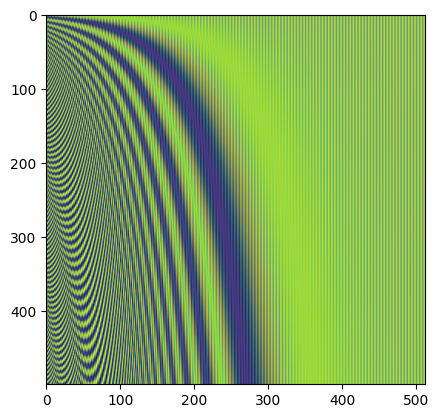

In [18]:
# example-use
import matplotlib.pyplot as plt

positional_encoding=PositionalEncoding(512, 500)
pe_table=positional_encoding.get_pe_table()

plt.imshow(pe_table.squeeze(0).numpy())
print(pe_table)

1. The vertical axis in imshow represents the position 𝑝 from 0 to 299.
2. The horizontal axis represents the embedding dimension 𝑖 from 0 to 511.

* At lower embedding dimensions (towards the left side of the heatmap), the sinusoidal frequency is relatively small, so the color changes more slowly down the rows.
* At higher embedding dimensions (towards the right side), the frequency is higher, so you see much more rapid changes in color as you move down the rows.

### 7.2 Add & Norm Layer

Helps propagate gradients easier and speeds up the learning process.

In [19]:
class AddAndNorm(nn.Module):
  def __init__(self, d_model):
    super(AddAndNorm, self).__init__()
    self.layer_norm=nn.LayerNorm(d_model)

  def forward(self, x, residual):
    return self.layer_norm(x+residual)

### 7.3 Position-wise Feed Forward Layer

Our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.
>This consists of **two linear transformations with a ReLU activation** in between.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSzERNAEx5xXxqQ4aSClTM73gfobTNq9cWPQ&s)

While the linear transformations are the same across different positions, they use different parameters from layer to layer.
>  The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality dff = 2048.

In [20]:
class PositionWiseFeedForwardNet(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForwardNet, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)

    # Optional Dropout (not mentioned in the paper)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    return self.w_2(self.dropout(torch.relu(self.w_1(x))))

### 7.4 Multi Head Attention Layer

Core of the transformer is the attention mechanism which enables creating **modified word representations** (attention representations) **that take into account the word's meaning in relation to other words in a sequence** (e.g. the word "bank" can represent a financial institution or a land along the edge of a river as in "river bank"). Core of the transformer is the attention mechanism which enables creating modified word representations (attention representations) that take into account the word's meaning in relation to other words in a sequence (e.g. the word "bank" can represent a financial institution or a land along the edge of a river as in "river bank").

**ATTENTION MECHANISM STEPS:**
* Obtain a **regular word embedding** for each word in a  sequence.
* With **learnable linear layer**, create **query**, **key** and **value** vector.
* **For each word's query calculate the match with each key using a dot product** (this dot product produces the attention weight, therefore dot product that produces a greater value signals that there is an important connection between those words.
* Once we have all the attention weights between pairs of queries and keys we **apply softmax** to restrict the attention weight values to [0,1] range.
* Finally, to get an attention representation for a word we **multiply attention weights** (which came from this word's query and all the keys) **with each word's value representation and sum all of them**.

This will yield a word representation that is aware of its context.

![](https://e2eml.school/images/transformers/attention_equation_QKT.png)

>We suspect that for large model dimensions, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by 1/sqrt(model_dimension).

#### 7.4.1 Scaled Dot Product Attention Layer
**MASKING**
One thing missing from the formula is the mask that is applied before softmax inside the attention mechanism. When applied, the mask sets all values that correspond to **unwanted connections to minus infinity**.

There are two types used:

1. Padding mask
2. Lookahead mask.
Padding mask prevents the attention mechanism inside the encoder to pay attention to padding tokens. Lookahead mask, used in the decoder, additionally prevents attending to positions over the current position.

When implemented in code it looks like this:


![](https://production-media.paperswithcode.com/methods/35184258-10f5-4cd0-8de3-bd9bc8f88dc3.png)

In [21]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, d_head):
    super(ScaledDotProductAttention, self).__init__()
    self.d_head = d_head

    # Optional dropout (not mentioned in the paper)
    self.attention_dropout = nn.Dropout(p=0.1)

  def forward(self, q, k, v, mask=None):
    # q, k, v dims: (batch_size, n_heads, seq_len, d_head)

    # 1. Matmul
    attention_weights = torch.matmul(q, k.transpose(-2, -1)) # (batch_size, n_heads, seq_len, seq_len)
    # 2. Scale
    scaled_attention_weights = attention_weights / math.sqrt(self.d_head) # (batch_size, n_heads, seq_len, seq_len)

    if mask is not None:
      # 3. Since the padding is 0 in all places, we replace all the zeros with -inf value
      scaled_attention_weights = scaled_attention_weights.masked_fill(mask == 0, float('-inf')) # (batch_size, n_heads, seq_len, seq_len)

    # 4. Apply softmax
    # After computing 𝑄𝐾^⊤, we want to find, for each query, how it “weights” or “attends to” each key. Mathematically, that means for each row (query), we want a probability distribution over all the columns (keys).Hence, we apply softmax over the “keys” dimension, not over the queries.
    scaled_attention_weights = nn.functional.softmax(scaled_attention_weights, dim=-1) # (batch_size, n_heads, seq_len, seq_len)

    # Optional dropout (not mentioned in the paper)
    scaled_attention_weights = self.attention_dropout(scaled_attention_weights) # (batch_size, n_heads, seq_len, seq_len)

    # 5. Matmul
    weighted_v = torch.matmul(scaled_attention_weights, v) # (batch_size, n_heads, seq_len, d_head)
    return weighted_v

#### 7.4.2 Multi Head Attention

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-08_at_12.17.05_AM_st5S0XV.png)

In [22]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super(MultiHeadAttention, self).__init__()
    self.n_heads= n_heads

    assert d_model % n_heads == 0

    self.d_head = d_model // n_heads
    self.dot_product_attention_layer= ScaledDotProductAttention(self.d_head)
    self.W_0 = nn.Linear(d_model, d_model)

  def _split_into_heads(self, q,k,v):
    q= q.view(q.size(0), q.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
    k= k.view(k.size(0), k.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
    v= v.view(v.size(0), v.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)

    q= q.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
    k= k.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
    v= v.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
    return q,k,v

  def _concatenate_heads(self,attention_output):
    # `.contiguous()` ensures that the tensor's memory layout is stored sequentially, making it safe for operations like `.view()`, which require continuous memory. Without it, `.view()` might throw an error if the tensor is non-contiguous due to operations like `.transpose()`.
    attention_output = attention_output.transpose(1,2).contiguous() # (batch_size, seq_len, n_heads, d_head)
    attention_output = attention_output.view(attention_output.size(0), attention_output.size(1), -1) # (batch_size, seq_len, n_heads * d_head)

    return attention_output

  def forward(self, q, k, v, mask=None):
    # original q, k, v --> (batch_size, seq_len, d_model) --> d_model is broken into n_heads * d_heads in the function of _split_into_heads
    q,k,v= self._split_into_heads(q,k,v) # (batch_size, n_heads, seq_len, d_heads)
    attention_output = self.dot_product_attention_layer(q, k, v, mask) # (batch_size, n_heads, seq_len, d_head)
    attention_output = self._concatenate_heads(attention_output) # (batch_size, seq_len, n_heads * d_head)
    attention_output = self.W_0(attention_output) # (batch_size, seq_len, d_model)
    return attention_output

## 8. Entire Transformer Encoder

### 8.1 Transformer Encoder Block

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*7sjcgd_nyODdLbZSxyxz_g.png)

In [23]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout_proba):
    super(TransformerEncoderBlock, self).__init__()

    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)

    self.mha_layer=MultiHeadAttention(d_model, n_heads)
    self.dropout_layer_1=nn.Dropout(dropout_proba)
    self.add_and_norm_layer_1 = AddAndNorm(d_model)

    self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
    self.dropout_layer_2=nn.Dropout(dropout_proba)
    self.add_and_norm_layer_2 = AddAndNorm(d_model)

  def forward(self, x, mask):
    # x dims: (batch_size, src_seq_len, d_model)
    # mask dim: (batch_size, 1, 1, src_seq_len)

    q = self.W_q(x) # (batch_size, src_seq_len, d_model)
    k = self.W_k(x) # (batch_size, src_seq_len, d_model)
    v = self.W_v(x) # (batch_size, src_seq_len, d_model)

    mha_out = self.mha_layer(q, k, v, mask) # (batch_size, src_seq_len, d_model)
    mha_out= self.dropout_layer_1(mha_out) # (batch_size, src_seq_len, d_model)
    mha_out = self.add_and_norm_layer_1(x, mha_out) # (batch_size, src_seq_len, d_model)

    ffn_out = self.ffn_layer(mha_out) # (batch_size, src_seq_len, d_model)
    ffn_out= self.dropout_layer_2(ffn_out) # (batch_size, src_seq_len, d_model)
    ffn_out = self.add_and_norm_layer_2(mha_out, ffn_out)  # (batch_size, src_seq_len, d_model)

    return ffn_out

### 8.2 Transformer Encoder



In [24]:
class TransformerEncoder(nn.Module):
  def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba=0.1):
    super(TransformerEncoder, self).__init__()

    self.encoder_blocks=nn.ModuleList([TransformerEncoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

  def forward(self, x, mask):
    for encoder_block in self.encoder_blocks:
      x = encoder_block(x, mask)
    return x

## 9. Entire Transformer Decoder

### 9.1 Tranformer Decoder Block
![](https://res.cloudinary.com/edlitera/image/upload/c_fill,f_auto/v1680629118/blog/gz5ccspg3yvq4eo6xhrr)

In [25]:
class TransformerDecoderBlock(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout_proba):
    super(TransformerDecoderBlock, self).__init__()

    self.W_q_1 = nn.Linear(d_model, d_model)
    self.W_k_1 = nn.Linear(d_model, d_model)
    self.W_v_1 = nn.Linear(d_model, d_model)

    self.mha_layer_1=MultiHeadAttention(d_model, n_heads)
    self.dropout_layer_1=nn.Dropout(dropout_proba)
    self.add_and_norm_1 = AddAndNorm(d_model)

    self.W_q_2 = nn.Linear(d_model, d_model)
    self.W_k_2 = nn.Linear(d_model, d_model)
    self.W_v_2 = nn.Linear(d_model, d_model)

    self.mha_layer_2=MultiHeadAttention(d_model, n_heads)
    self.dropout_layer_2=nn.Dropout(dropout_proba)
    self.add_and_norm_2 = AddAndNorm(d_model)

    self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
    self.dropout_layer_3=nn.Dropout(dropout_proba)
    self.add_and_norm_3 = AddAndNorm(d_model)

  def forward(self, x, encoder_output, src_mask, trg_mask):
    # x dims: (batch_size, trg_seq_len, d_model)
    # encoder_output dims: (batch_size, src_seq_len, d_model)
    # src_mask dim: (batch_size, 1, 1, src_seq_len)
    # trg_mask dim: (batch_size, 1, trg_seq_len, trg_seq_len)

    # 1st attention layer, trg_mask is used here
    q_1 = self.W_q_1(x) # (batch_size, trg_seq_len, d_model)
    k_1 = self.W_k_1(x) # (batch_size, trg_seq_len, d_model)
    v_1 = self.W_v_1(x) # (batch_size, trg_seq_len, d_model)

    mha_layer_1_out = self.mha_layer_1(q_1, k_1, v_1, trg_mask) # (batch_size, trg_seq_len, d_model)
    mha_layer_1_out= self.dropout_layer_1(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
    mha_layer_1_out = self.add_and_norm_1(mha_layer_1_out, x) # (batch_size, trg_seq_len, d_model)

    # 2nd attention layer, src_mask is used here
    q_2 = self.W_q_2(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
    k_2 = self.W_k_2(encoder_output) # (batch_size, src_seq_len, d_model)
    v_2 = self.W_v_2(encoder_output) # (batch_size, src_seq_len, d_model)

    mha_layer_2_out = self.mha_layer_2(q_2, k_2, v_2, src_mask) # (batch_size, trg_seq_len, d_model)
    mha_layer_2_out= self.dropout_layer_2(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
    mha_layer_2_out = self.add_and_norm_2(mha_layer_2_out, mha_layer_1_out) # (batch_size, trg_seq_len, d_model)

    # Position-wise feed forward
    ffn_out = self.ffn_layer(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
    ffn_out= self.dropout_layer_3(ffn_out) # (batch_size, trg_seq_len, d_model)
    ffn_out = self.add_and_norm_3(ffn_out, mha_layer_2_out) # (batch_size, trg_seq_len, d_model)

    return ffn_out

### 9.2 Transformer Decoder

In [26]:
class TransformerDecoder(nn.Module):
  def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba):
    super(TransformerDecoder, self).__init__()

    self.decoder_blocks=nn.ModuleList([TransformerDecoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

  def forward(self, x, encoder_output, src_mask, trg_mask):
    for decoder_block in self.decoder_blocks:
      x = decoder_block(x, encoder_output, src_mask, trg_mask)
    return x

## 10. Full Encoder-Decoder Transformer

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*SikzJ5iL95KcOr5tNzvOmQ.png)

In [27]:
class TransformerEncoderDecoder(nn.Module):
  def __init__(self,d_model, n_blocks, src_vocab_size, trg_vocab_size, n_heads, d_ff, dropout_proba):
    super(TransformerEncoderDecoder, self).__init__()
    self.dropout_proba = dropout_proba
    self.d_model=d_model

    # Encoder part
    self.src_embedding = nn.Embedding(src_vocab_size, d_model)
    self.src_pos_embedding= PositionalEncoding(d_model)
    self.encoder= TransformerEncoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

    # Decoder part
    self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
    self.trg_pos_embedding= PositionalEncoding(d_model)
    self.decoder= TransformerDecoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

    # Linear mapping to vocab size
    self.linear = nn.Linear(d_model, trg_vocab_size)

    # Switch to xavier initialization (shown to be beneficial)
    self.init_with_xavier()

    # Sharing weights between two embedding layers and the pre-softmax linear layer
    # The model uses self.src_embedding for encoding source tokens.
    # The model uses self.trgt_embedding for encoding target tokens.
    # Instead of separately learning two embedding matrices, this line shares the weights:
    self.src_embedding.weight = self.trg_embedding.weight
    # Before applying softmax, the model has a linear transformation (self.linear_mapping).
    # Instead of learning new weights for this layer, it reuses the target embedding weights:
    self.linear.weight = self.trg_embedding.weight

  def encode(self, src_token_ids, src_mask):
    # Encoder part
    src_embeddings = self.src_embedding(src_token_ids) * math.sqrt(self.d_model) # (batch_size, src_seq_len, d_model)
    src_embeddings = self.src_pos_embedding(src_embeddings) # (batch_size, src_seq_len, d_model)
    encoder_outputs = self.encoder(src_embeddings, src_mask) # (batch_size, src_seq_len, d_model)
    return encoder_outputs

  def decode(self, trg_token_ids, encoder_outputs, src_mask, trg_mask):
    # Decoder part
    trg_embeddings = self.trg_embedding(trg_token_ids) * math.sqrt(self.d_model) # (batch_size, trg_seq_len, d_model)
    trg_embeddings = self.trg_pos_embedding(trg_embeddings) # (batch_size, trg_seq_len, d_model)
    decoder_outputs = self.decoder(trg_embeddings, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)
    # Linear mapping to vocab size
    linear_out = self.linear(decoder_outputs) # (batch_size, trg_seq_len, trg_vocab_size)
    return linear_out

  def forward(self, src_token_ids, trg_token_ids, src_mask, trg_mask):

    encoder_outputs= self.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)
    decoder_outputs= self.decode(trg_token_ids, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)
    return decoder_outputs

  def init_with_xavier(self):
    for name, p in self.named_parameters():
    # Ensures that only weight tensors (which have more than one dimension) are initialized. Bias terms (which are usually 1D) are ignored since Xavier is primarily meant for weight matrices.
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

### **What does Xavier Initialization do?**  
Xavier Initialization (also called **Glorot Initialization**) is a method to initialize the weights of a neural network in a way that helps with **better training and stable gradients**.

### **Why do we need it?**  
- If weights are **too small**, the signal becomes weaker as it moves through layers (**vanishing gradients**).  
- If weights are **too large**, activations explode (**exploding gradients**).  
- **Xavier initializes weights so that the variance is balanced, preventing both issues.**  

### **How does it work?**  
For a given weight matrix **W** of shape `(fan_in, fan_out)`, where:  
- `fan_in` = Number of input neurons (to a layer)  
- `fan_out` = Number of output neurons (from a layer)  

**Xavier sets the weights as:**
$$
W \sim U\left(-\frac{\sqrt{6}}{\sqrt{\text{fan\_in} + \text{fan\_out}}}, \frac{\sqrt{6}}{\sqrt{\text{fan\_in} + \text{fan\_out}}}\right)
$$
This means the weights are sampled **uniformly** from a small range that depends on the layer size.

### **Example in Simple Terms**  
#### **Without Xavier Initialization (Random Initialization)**
- Imagine you're filling a **glass** with water but pouring **too much or too little**.
- If you pour too much, it **overflows** (**exploding gradients**).  
- If you pour too little, the glass is **almost empty** (**vanishing gradients**).  

#### **With Xavier Initialization**
- It helps you **pour just the right amount** so that water is evenly distributed in the glass—**not too much, not too little**.  
- This ensures stable training and better convergence.

### **Code Example**
```python
import torch
import torch.nn as nn

layer = nn.Linear(256, 128)  # A layer with 256 input neurons, 128 output neurons
nn.init.xavier_uniform_(layer.weight)  # Apply Xavier initialization


## 11. Wrap the Transformer into a Machine Translation Transformer Model

In [28]:
class MachineTranslationTransformer(nn.Module):
  def __init__(self, d_model,n_blocks,src_vocab_size,trg_vocab_size,n_heads,d_ff, dropout_proba):
    super(MachineTranslationTransformer, self).__init__()

    self.transformer_encoder_decoder=TransformerEncoderDecoder(
      d_model,
      n_blocks,
      src_vocab_size,
      trg_vocab_size,
      n_heads,
      d_ff,
      dropout_proba
    )

  def _get_pad_mask(self, token_ids, pad_idx=0):
    pad_mask= (token_ids != pad_idx).unsqueeze(-2) # (batch_size, 1, seq_len)
    return pad_mask.unsqueeze(1)

  def _get_lookahead_mask(self, token_ids):
    sz_b, len_s = token_ids.size()
    subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=token_ids.device), diagonal=1)).bool()
    return subsequent_mask.unsqueeze(1)

  def forward(self, src_token_ids, trg_token_ids):
    # Since trg_token_ids contains both [BOS] and [SOS] tokens
    # we need to remove the [EOS] token when using it as input to the decoder.
    # Similarly we remove the [BOS] token when we use it as y to calculate loss,
    # which also makes y and y_pred shapes match.

    # Since the target sequence contains both start-of-sequence ([BOS]) and end-of-sequence ([EOS]) tokens, the code removes the last token ([EOS]) for the decoder input
    trg_token_ids=trg_token_ids[:, :-1]

    src_mask = self._get_pad_mask(src_token_ids) # (batch_size, 1, 1, src_seq_len)
    trg_mask = self._get_pad_mask(trg_token_ids) & self._get_lookahead_mask(trg_token_ids)  # (batch_size, 1, trg_seq_len, trg_seq_len)

    return self.transformer_encoder_decoder(src_token_ids, trg_token_ids, src_mask, trg_mask)

  def preprocess(self, sentence, tokenizer):
    """
    Convert sentence into token IDs
    Steps:
    1. Tokensize
    2. Turn the token_ids into tensor
    3. Add the batch dimension
    """
    device = next(self.parameters()).device

    src_token_ids=tokenizer.encode(sentence).ids
    src_token_ids=torch.tensor(src_token_ids, dtype=torch.long).to(device)
    src_token_ids=src_token_ids.unsqueeze(0) # To batch format

    return src_token_ids

  def translate(self, sentence, tokenizer, max_tokens=100, skip_special_tokens=False):
    # Infer the device of the model
    device = next(self.parameters()).device

    # Get tokenizer special tokens.
    eos_id=tokenizer.token_to_id('[EOS]')
    bos_id=tokenizer.token_to_id('[BOS]')
    pad_id = tokenizer.token_to_id('[PAD]')

    # Tokenize sentence.
    src_token_ids=self.preprocess(sentence, tokenizer)

    # Initialize target sequence with SOS token.
    trg_token_ids=torch.LongTensor([bos_id]).unsqueeze(0).to(device) # (1, 1)

    # Obtain src mask
    src_mask=self._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

    # with torch.no_grad():
    encoder_output=self.transformer_encoder_decoder.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)

    # Start the Decoding Loop
    # The function now enters a loop that generates one token at a time until an [EOS] token is produced or the maximum token count is reached
    while True:
      # Obtain decoder output.
      trg_mask=self._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
      decoder_output=self.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask, trg_mask)

      # Identify token with highest probability.
      softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
      # The logits are converted into log probabilities. Only the probabilities for the last position (the newest token) are considered.
      softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
      _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

      # Check if token is EOS or we reached the maximum number of tokens.
      if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
        trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
        break

      # Add token to target sequence.
      trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

    # Detokenize sentence.
    decoded_output=tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

    return decoded_output

## 12. Define Cutom Schedular

In [29]:
class CustomScheduler():
  def __init__(self, optimizer, d_model, n_warmup_steps=4000):
    self.optimizer = optimizer
    self.d_model = d_model

    # During these steps, the learning rate increases linearly; afterwards, it decays. Default is set to 4000.
    self.n_warmup_steps = n_warmup_steps
    self.cur_step = 0
    self.cur_lr=None

    # Init LR right away
    self.step()

  def step(self):
    self.cur_step += 1
    self.cur_lr=self._get_lr()
    for p in self.optimizer.param_groups:
      """
      The optimizer may contain several parameter groups. This loop updates the learning rate (lr) for each group.
      This ensures that every part of your model uses the same learning rate computed by the scheduler.
      """
      p['lr'] = self.cur_lr

  def _get_lr(self):
    return self.d_model**(-0.5) * min(self.cur_step**(-0.5), self.cur_step*self.n_warmup_steps**(-1.5))

  def get_last_lr(self):
    return [group['lr'] for group in self.optimizer.param_groups]

  def zero_grad(self):
    """
    A convenience function to reset (zero) the gradients of the optimizer. This is useful because before starting a new backward pass, gradients from the previous step need to be cleared.
    """
    self.optimizer.zero_grad()

## 13. Initialize Training Configuration

In [30]:
model = MachineTranslationTransformer(
  d_model=config['D_MODEL'],
  n_blocks=config['N_BLOCKS'],
  src_vocab_size=config['VOCAB_SIZE'],
  trg_vocab_size=config['VOCAB_SIZE'],
  n_heads=config['N_HEADS'],
  d_ff=config['D_FF'],
  dropout_proba=config['DROPOUT_PROBA']
)

## 14. Loss Function and Optimizer

In [31]:
loss_func = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=config['LABEL_SMOOTHING'], reduction='mean')
optimizer = optim.Adam(model.parameters(), betas=config['BETAS'], eps=config['EPS'])
scheduler=CustomScheduler(optimizer, config['D_MODEL'], config['N_WARMUP_STEPS'])

In [32]:
if config['DEVICE']=='gpu':
  device='cuda'
else:
  device='cpu'

## 15. Training Loop

In [37]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

cur_step=1
model.to(device)
for epoch_idx in range(config['EPOCHS']):
  # Train
  train_loss=0
  model.train()
  for batch_idx, batch in enumerate(train_dl):
    xb,yb=batch
    xb,yb =xb.to(device),yb.to(device)
    preds=model(xb,yb)

    loss=loss_func(
      preds.reshape(-1, preds.size(-1)), # Reshaping for loss
      yb[:,1:].contiguous().view(-1) # yb[:, 1:] removes the first token (often a [BOS] token) because we predict the next tokens, and .contiguous().view(-1) flattens the target tensor to match the prediction shape.
    )
    train_loss+=loss.detach().cpu()

    loss.backward()
    # Instead of updating the weights after every batch, updates occur every GRAD_ACCUMULATION_STEPS batches.
    if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      cur_step+=1

  # Validation
  val_loss=0
  with torch.no_grad():
    model.eval()
    for batch_idx, batch in enumerate(val_dl):
      xb,yb=batch
      xb,yb =xb.to(device),yb.to(device)
      preds=model(xb,yb)

      loss=loss_func(
        preds.reshape(-1, preds.size(-1)), # Reshaping for loss
        yb[:,1:].contiguous().view(-1) # Shifting right (without BOS)
      )
      val_loss+=loss.detach().cpu()

  print(f"Epoch: {epoch_idx}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

Epoch: 0, Train Loss: 5843.3037109375, Validation Loss: 66.00440979003906
Epoch: 1, Train Loss: 5843.3935546875, Validation Loss: 66.00440979003906
Epoch: 2, Train Loss: 5843.31103515625, Validation Loss: 66.00440979003906
Epoch: 3, Train Loss: 5843.3037109375, Validation Loss: 66.00440979003906
Epoch: 4, Train Loss: 5843.1953125, Validation Loss: 66.00440979003906
Epoch: 5, Train Loss: 5843.33447265625, Validation Loss: 66.00440979003906
Epoch: 6, Train Loss: 5843.34619140625, Validation Loss: 66.00440979003906
Epoch: 7, Train Loss: 5843.244140625, Validation Loss: 66.00440979003906
Epoch: 8, Train Loss: 5843.3056640625, Validation Loss: 66.00440979003906
Epoch: 9, Train Loss: 5843.29443359375, Validation Loss: 66.00440979003906
Epoch: 10, Train Loss: 5843.2490234375, Validation Loss: 66.0044174194336
Epoch: 11, Train Loss: 5843.2919921875, Validation Loss: 66.0044174194336
Epoch: 12, Train Loss: 5843.25390625, Validation Loss: 66.00440979003906
Epoch: 13, Train Loss: 5843.25244140625

## 16. Inference

In [38]:
input_sentence='what is the temperature today? '

In [39]:
model.translate(input_sentence, tokenizer)

'[BOS] wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden wooden'